# A2e Exploration  
Finn Hittson - fxh157  
CSDS 464  
Due: Feburary 23rd, 2023  

## Outline
For my research extension, I am be building a beat detection system. This system is an implementation of an algorithm proposed in the paper *Streamlined Tempo Estimation Based on
Autocorrelation and Cross-correlation With Pulses*, published December 12th, 2014 and written by Graham Percival and George Tzanetakis. The paper is included in the files provided.
The algorithms outline is broken down into three components:  
1. Generate onset signal strength (OSS): This step transforms the audio signal into a signal that indicates where human ears percieve onsets. The signal is the output of the OSS step.
2. Beat period detection (BPD): The signal generated from OSS is parsed into smaller segments which are then analyzed for the tempo. The output is a single digit which is an estimate of the tempo from the original audio input. 
3. Accumulator and overall estimate: Tempo estimates are accumulated and an overall estimate is determined from these samples. A heuristic is used to evaluate whether the tempo is correct and whether the it should be halved or doubled since this estimation method can produce tempo estimates that are either double or half the the true tempo.  
  
If time permits I will also add a visualization of the tempo to demonstrate its tempo estimation capability with music.

## A2e Progress
For this progress report I have nearly completed implementing this first step of the algorithm, OSS. OSS has 4 subcomponents. 
1. Overlap: Separate the audio signal into overlapping frames with $1024$ samples per frame and hop size of $128$.
2. Log Power Spectrum: Multiply each frame by the Hamming window function. This is done to slightly smooth the data and prep it for computing the Discretized Fourier Transform (DFT). The equation below describe the Hamming window.
\begin{equation}
w(n)=0.54-0.46\cos\left(\frac{2\pi n}{M-1}\right)\ \ \ \ \ n\le M-1
\end{equation}
Next compute the DFT which transforms the signal from the time domain to the frequency domain. This process uses each frame to create a new array of equal length where each value is a complex number whose parts describe the magnitude and phase of a sinusoidal wave that is part of the underlying signal. Using this information, the log power spectrum is defined as 
\begin{equation}
L_P(k,n)=\ln(1+1000\cdot|X(k,n)|)
\end{equation}
$|X(k,n)|$ is the magnitude spectrum of frame $n$ at frequency bin $k$ so it effectivly the modulus of the complex number. 
3. Flux: Compute the spectral flux with the following equation: 
\begin{equation}
Flux(n)=\sum_{k=1}^{N-1}(L_P(k,n)-L_P(k,n-1))\cdot I_{PF}(k,n)
\end{equation}
where
\begin{equation}
I_{PF}(k,n)=
\begin{cases}
1 & 0\ \textrm{if}\ |X(k,n)|-|X(k,n-1)|\le0\\
0 & 1\ \textrm{otherwise}
\end{cases}
\end{equation}
The flux is the sum of of the log magnitude from the frequency bins that have a positive change of log magnitude over time. $I_{PF}(k,n)$ ensures that only positive changes are sumed and negative changes are negatted. This step reduces the signal down to a one dimensional signal.
4. Low-pass Filter: The final step of OSS is passing the signal through a $14^{\textrm{th}}$ order low pass filter with a cutoff frequency of $7Hz$. The filter was designed using the Hamming window method from the begining of step 2 and the output is a smoothed signal for the BPD part of the algorithm.  

I have completed up to step $4$ of the OSS portion of the algorithm. I am currently researching how to design a proper FIR filter. I am also waiting for a lecture on this subject since Professor Lewicki has mentioned that we will be covering signal processing soon. For the code demonstration below, I have build functions to complete the signal processing outline in steps 1, 2 and 3. The paper also demonstrates these steps through the transformed signal through plots so I replecate these plots using the same signal source which is a $30$ second clip of a ballroom dance song. 

## OSS

### 1. Overlap

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math

# open and read .wav file
def read_wav(filepath):
    sr, data = wavfile.read(filepath)
    return sr, data

# parse audio signal into overlapping frames
def frames(data, framesize, hop):
    frames = []
    tmp = []
    for i in range(len(data)):
        tmp.append(data[i])
        if len(tmp) == framesize:
            frames.append(tmp)
            tmp = tmp[-hop:]
    return np.array(frames)

In [13]:
# plots raw signal
def plot_signal(data, sr:int=44100, endtime:int=6, title:str="Raw Signal"):
    y = data[:int(endtime*sr)]
    x = list(range(len(y)))
    plt.figure().set_figheight(2)
    plt.plot(x, y, 'k', linewidth=0.2)
    plt.xlabel("time/seconds", fontsize=10)
    plt.ylabel("audio", fontsize=10)
    plt.title(title, fontsize=12)
    labels = list(range(0,7,1))
    ticks = [int(len(y)/endtime)*i for i in labels]
    plt.xticks(ticks=ticks, labels=labels)
    labels = range(-1, 2, 1)
    ticks = [min(data), 0, max(data)]
    plt.yticks(ticks=ticks, labels=labels)
    plt.show()

# plots frames
def plot_frames(frames, sr:int=44100, endtime:int=6, hop:int=128, title:str="Overlap", scatter:str=False):
    y = np.array([])
    for idx, frame in enumerate(frames):
        if idx == 0: y = frame
        else: y = np.concatenate((y, frame[128:]), axis=None)
    y = y[:endtime*sr]
    x = list(range(len(y)))
    plt.figure().set_figheight(2)
    if scatter:
        plt.scatter(x, y, c='k', s=0.1, marker='.')
    else:
        plt.plot(x, y, 'k', linewidth=0.1)

    plt.xlabel("time/seconds", fontsize=10)
    if title == "Overlap":
        plt.ylabel("audio", fontsize=10)
        labels = range(-1, 2, 1)
        ticks = [min(data), 0, max(data)]
        plt.yticks(ticks=ticks, labels=labels)
    else:
        plt.ylabel("freq/kHz", fontsize=10)
        plt.yticks([0,5,10,15,20])
        
    labels = list(range(0,7,1))
    ticks = [sr*i for i in labels]
    plt.xticks(ticks=ticks, labels=labels)
    plt.title(title, fontsize=12)
    plt.show()

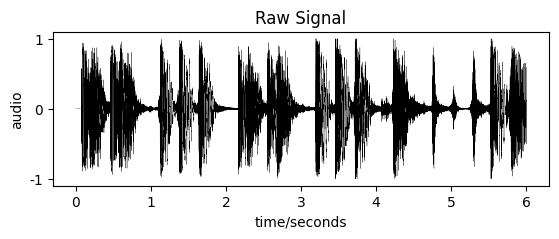

In [14]:
filepath = "ballroom.wav"
sr, data = read_wav(filepath)
plot_signal(data, sr, title="Raw Signal")

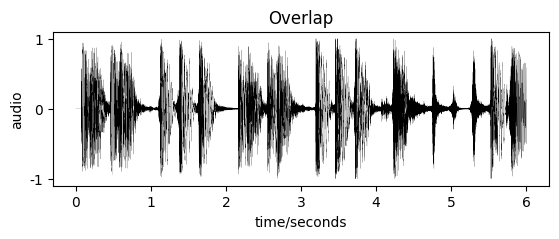

In [4]:
framesize = 1024
hop = 128
f = frames(data, framesize, hop)
plot_frames(f, title="Overlap")

### 2. Log Power Spectrum

In [5]:
# multiplies frames by the hamming window function
def hamming_window(frames):
    M = len(frames[0])
    t = np.linspace(-M/2, M/2, M)
    window = np.array([0.54 + 0.46*math.cos(2*math.pi*i/(M-1)) for i in t])
    #window = scipy.signal.hamming(M=M)
    return np.array([frame*window for frame in frames])

# computes the log power spectrum of the frequency bins
def log_power(fft_frames):
    return [[math.log(1 + 1000*abs(amp)) for amp in frame] for frame in fft_frames]

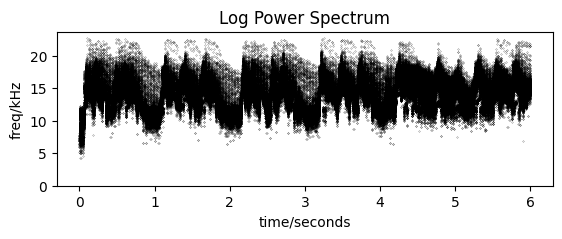

In [6]:
tappered_frames = hamming_window(f)
# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames)
lp = np.array(log_power(fft_frames))
plot_frames(lp, title="Log Power Spectrum", scatter=True)

### 3. Flux

In [7]:
# computes the flux of the signal
def flux(lp, fft_frames):
	flux = []
	for n in range(1,len(lp)):
		frame_flux = 0
		for k in range(len(lp[n])):
			if abs(fft_frames[n,k]) - abs(fft_frames[n-1,k]) > 0:
				frame_flux += lp[n,k] - lp[n-1,k]
		flux.append(frame_flux)
	return flux

# plots flux
def plot_flux(flux, endtime:int=6):
	y = flux
	x = list(range(len(y)))
	plt.figure().set_figheight(2)
	plt.plot(x, flux, 'k', linewidth=0.5)
	plt.xlabel("time/seconds", fontsize=10)
	plt.ylabel("flux", fontsize=10)
	plt.title("Flux", fontsize=12)
	labels = list(range(0,7,1))
	ticks = [len(flux)*i/6 for i in labels]
	plt.xticks(ticks=ticks, labels=labels)
	labels = [0, 20, 40, 60, 80]
	ticks = [max(flux)*i/80 for i in labels]
	plt.yticks(ticks=ticks, labels=labels)
	plt.show()

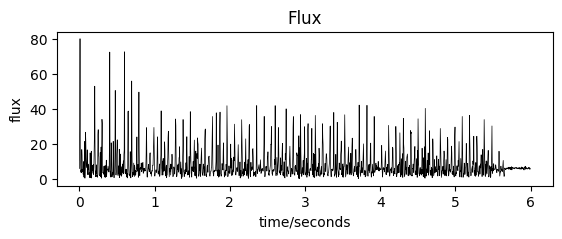

In [8]:
flx = flux(lp, fft_frames)
plot_flux(flx)

### 4. Low-pass Filter

In [9]:
def low_pass_filter(flux):
    b = scipy.signal.firwin(numtaps=14, cutoff=7, fs=344.5)
    y = []
    for i in range(0, 14*math.floor(len(flux)/14), 7):
        tmp = 0
        for j in range(14):
            tmp += b[j]*flux[i+j]
        y.append(tmp)
    return y

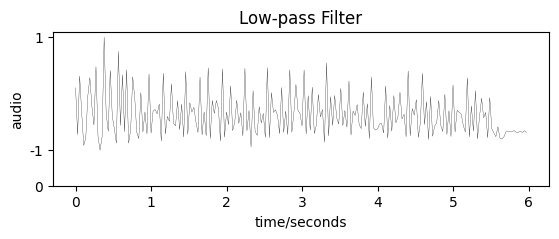

In [15]:
y = low_pass_filter(flx)
plot_signal(y, sr=344.5, title="Low-pass Filter")